In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.6043
SVM (RBF Kernel) Average Accuracy: 0.6084
Random Forest Average Accuracy: 0.8756
AdaBoost Average Accuracy: 0.1550
Extra Trees Average Accuracy: 0.8786

Best performing model: Extra Trees with Average Accuracy: 0.8786

Test Accuracy of the best model (Extra Trees): 0.9033


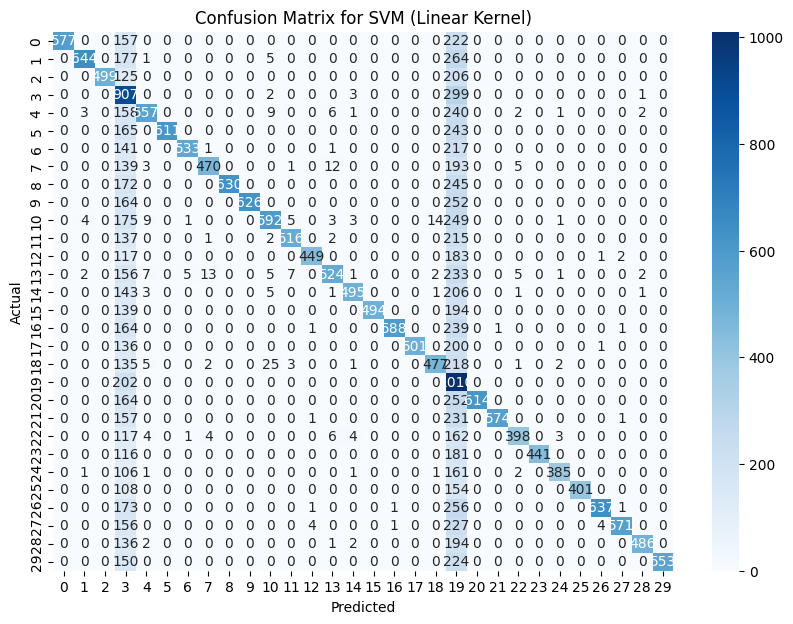

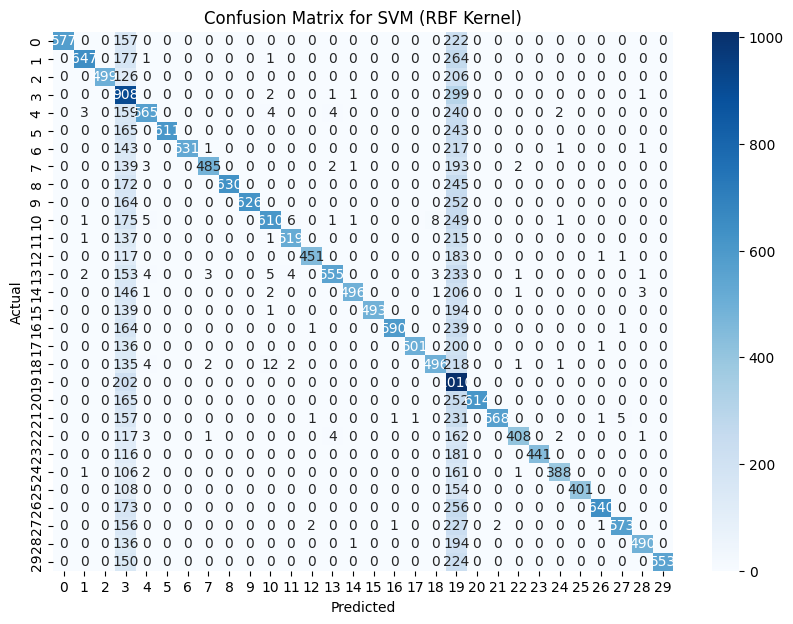

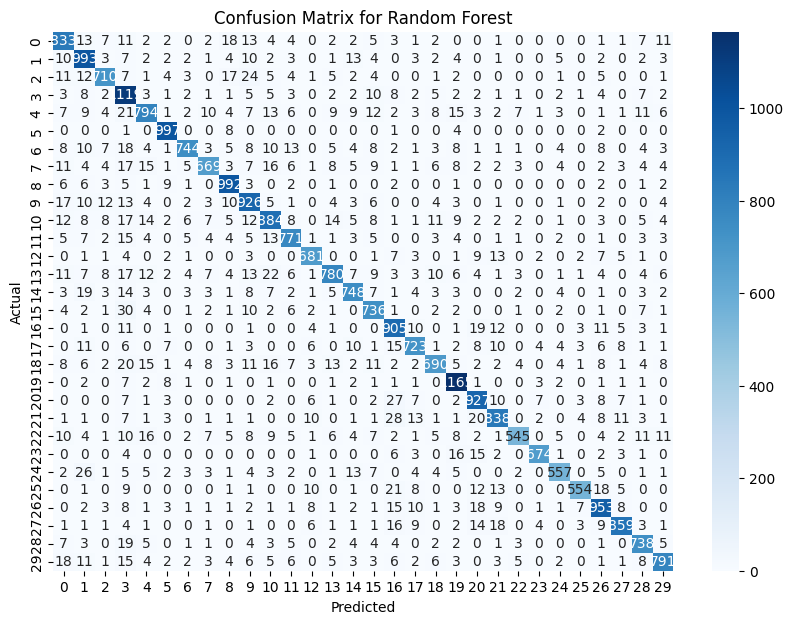

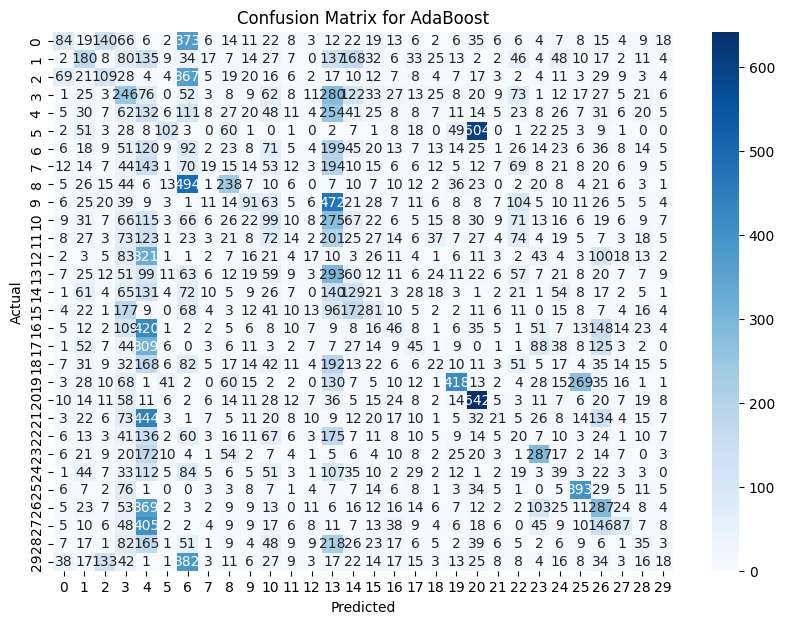

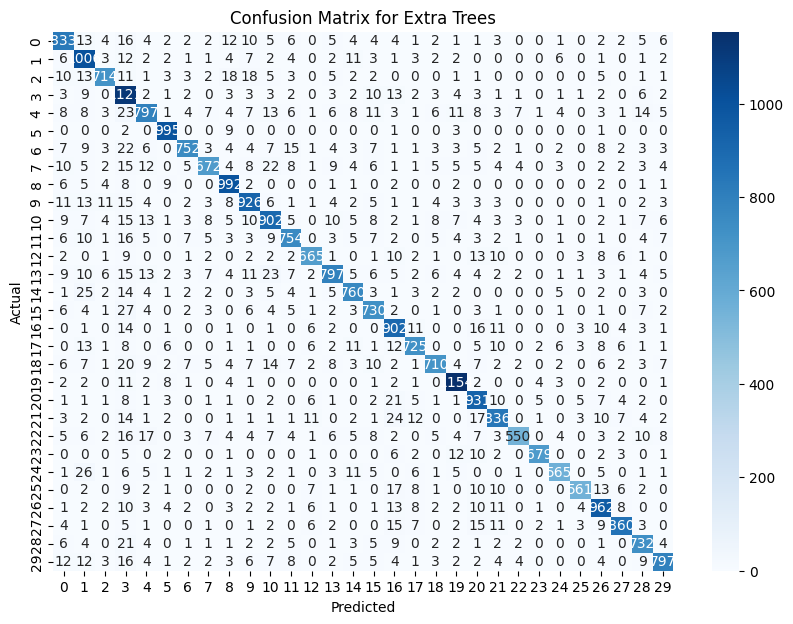


Confusion Matrix for Extra Trees:
[[1068   23    3   24    7    2    0    2    9    7    3    8    1    2
     3    4    3    2    1    3    3    2    2    0    0    0    2    1
    11    7]
 [   6 1220    0   14    0    0    2    0    4    6    1    1    1    3
     9    3    0    2    0    1    0    0    0    0    6    2    4    0
     2    2]
 [   6   13  914   12    2    2    2    1   17   27    8    0    0    3
     1    0    4    1    1    0    1    1    0    0    0    0    7    0
     3    1]
 [   3    7    2 1392    6    0    3    1    1    2    3    1    0    0
     0   11    8    1    2    1    2    0    2    2    3    0    1    0
     2    6]
 [   6   11    6   22 1083    0    2    2    4   15   18   11    3   12
    14   10    6    2    7   11    5    8   15    0    0    0    3    0
     5    7]
 [   1    0    2    2    0 1245    0    0   10    2    0    1    0    0
     0    0    2    0    0    3    1    0    0    1    0    0    3    1
     0    0]
 [   9    9    2   18  

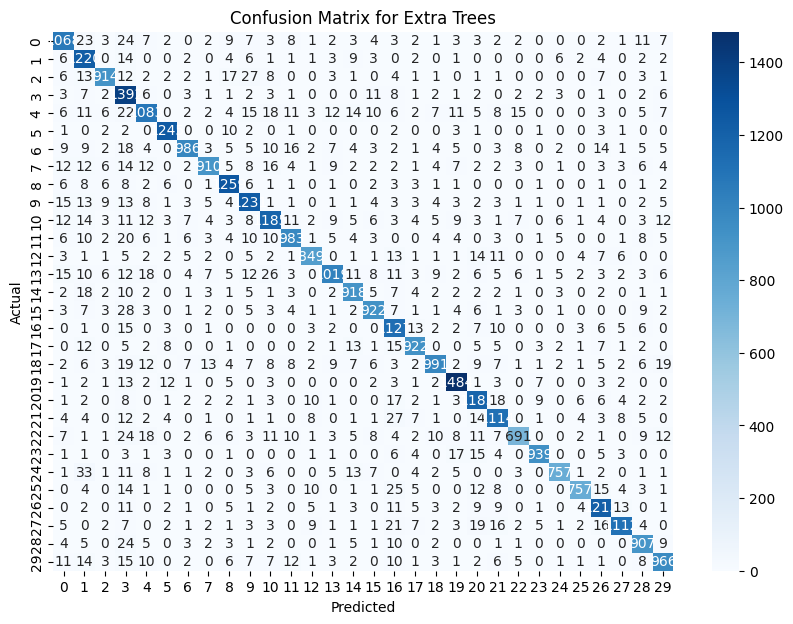

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/forklift_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=1):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.5992
SVM (RBF Kernel) Average Accuracy: 0.5988
Random Forest Average Accuracy: 0.8335
AdaBoost Average Accuracy: 0.1484
Extra Trees Average Accuracy: 0.8323

Best performing model: Random Forest with Average Accuracy: 0.8335

Test Accuracy of the best model (Random Forest): 0.8491


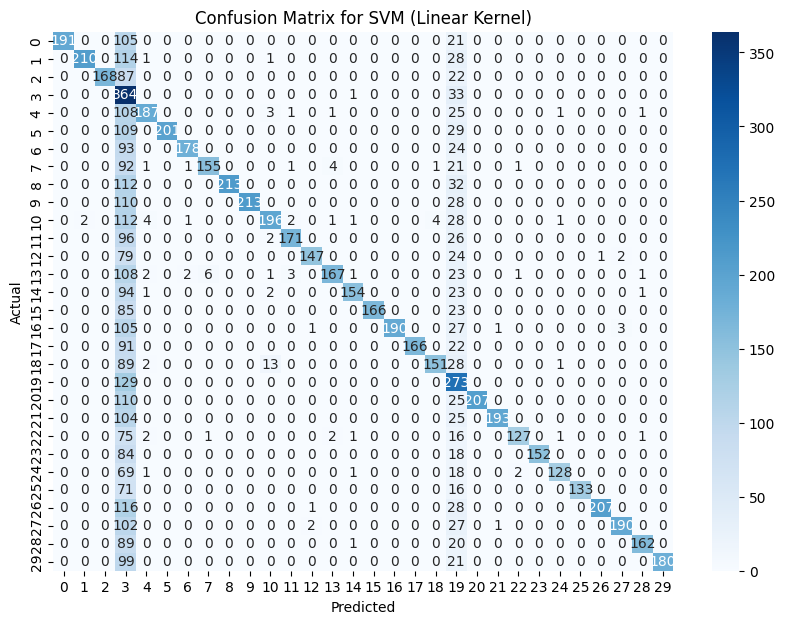

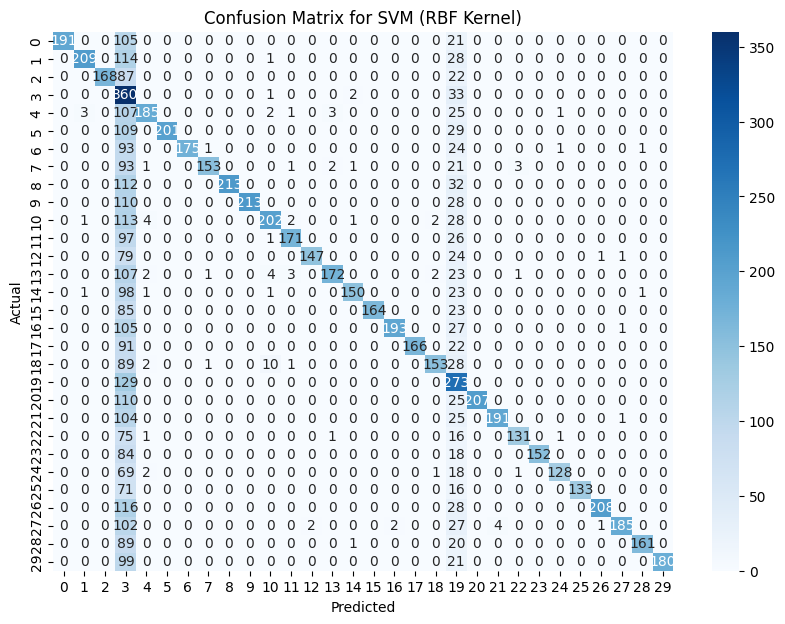

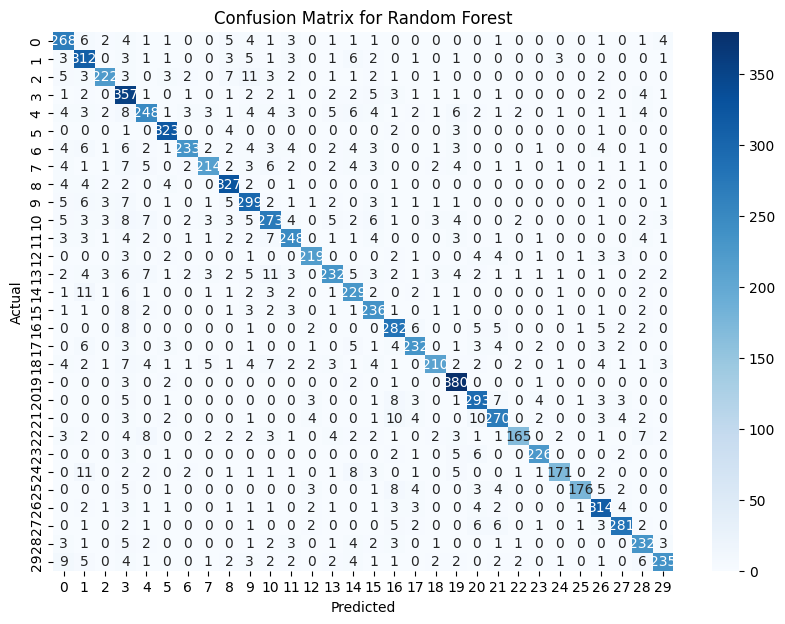

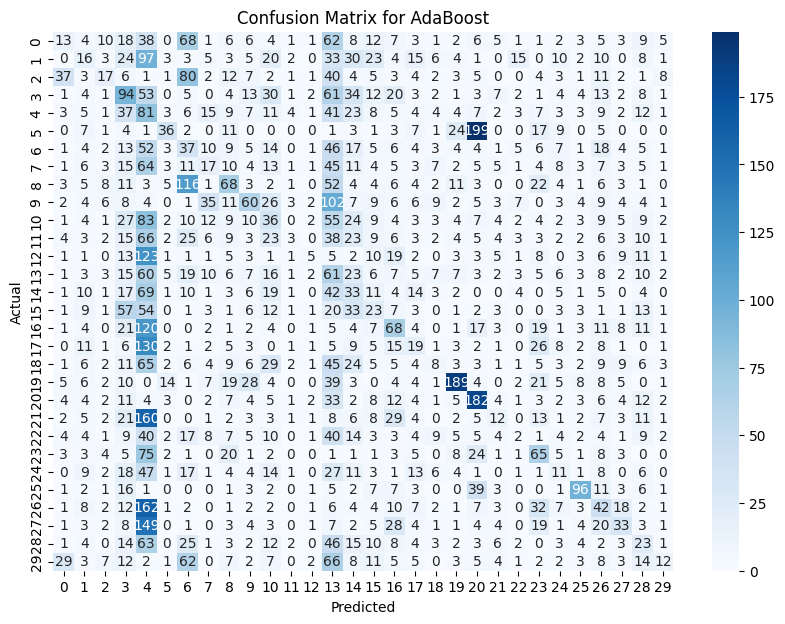

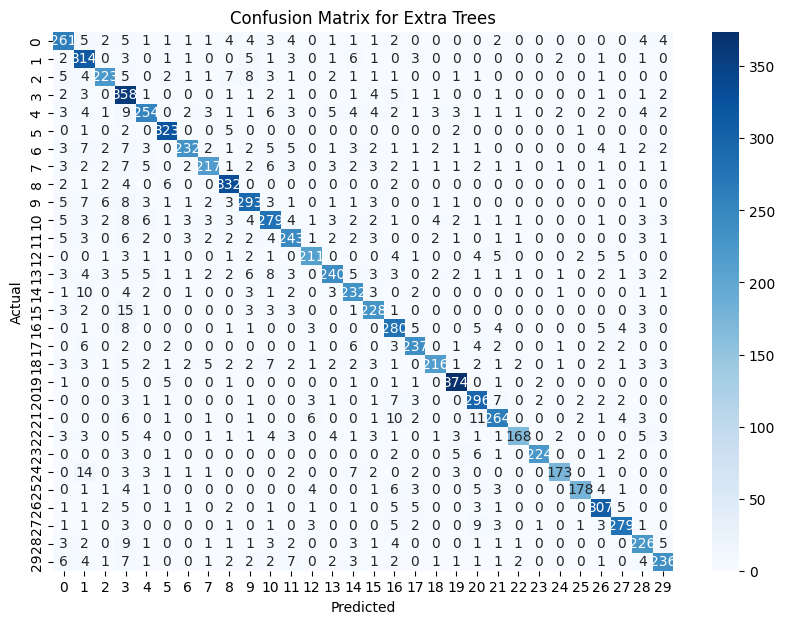


Confusion Matrix for Random Forest:
[[351   6   2   5   0   2   0   0   7   4   2   1   1   0   2   1   5   1
    3   0   1   1   2   0   1   0   0   1   3   7]
 [  5 416   4   3   1   1   3   0   1   7   2   1   1   1   8   2   0   2
    0   2   0   1   0   0   3   1   5   1   1   0]
 [  9   1 280   6   2   3   2   0   9  13   1   0   1   2   2   1   0   0
    1   0   0   0   0   0   1   0   5   0   0   1]
 [  2   2   2 466   0   1   1   0   2   1   2   0   0   1   3   6   3   1
    3   3   2   1   1   0   1   1   5   0   2   1]
 [  6   7   0   8 311   3   1   6   4   5   8   2   1   5   4   3   2   2
    9   6   1   2   4   2   0   0   2   0   2   3]
 [  1   0   1   2   0 408   0   0   4   1   0   0   1   0   0   0   1   0
    0   3   0   2   0   0   0   0   0   0   1   0]
 [  3   8   1   5   3   0 295   3   5   5   3   8   2   4   7   4   1   0
    0   5   1   0   0   0   0   1   5   1   3   2]
 [  4   4   0   7  12   0   1 266   3   4   6   0   0   1   0   3   1   0
    1   6   1 

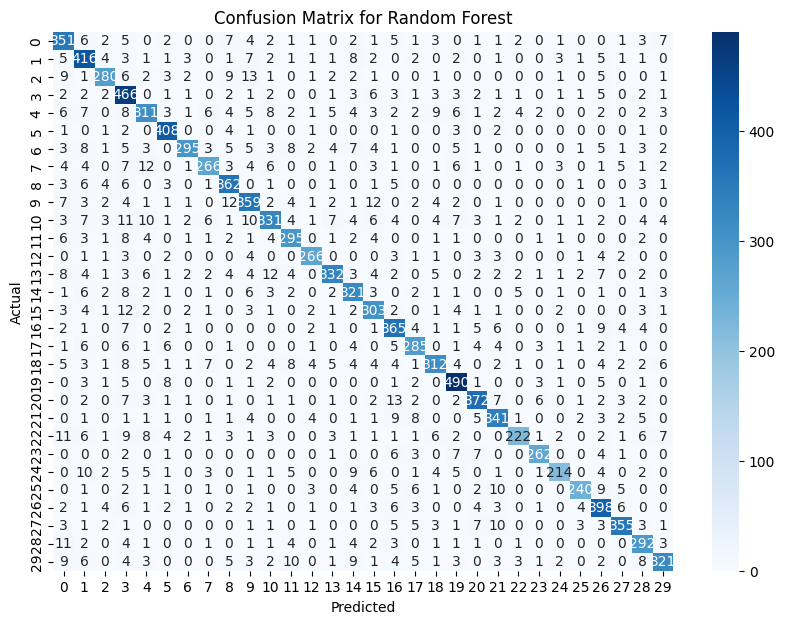

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/forklift_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=3):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.5942
SVM (RBF Kernel) Average Accuracy: 0.5911
Random Forest Average Accuracy: 0.8106
AdaBoost Average Accuracy: 0.1313
Extra Trees Average Accuracy: 0.8136

Best performing model: Extra Trees with Average Accuracy: 0.8136

Test Accuracy of the best model (Extra Trees): 0.8431


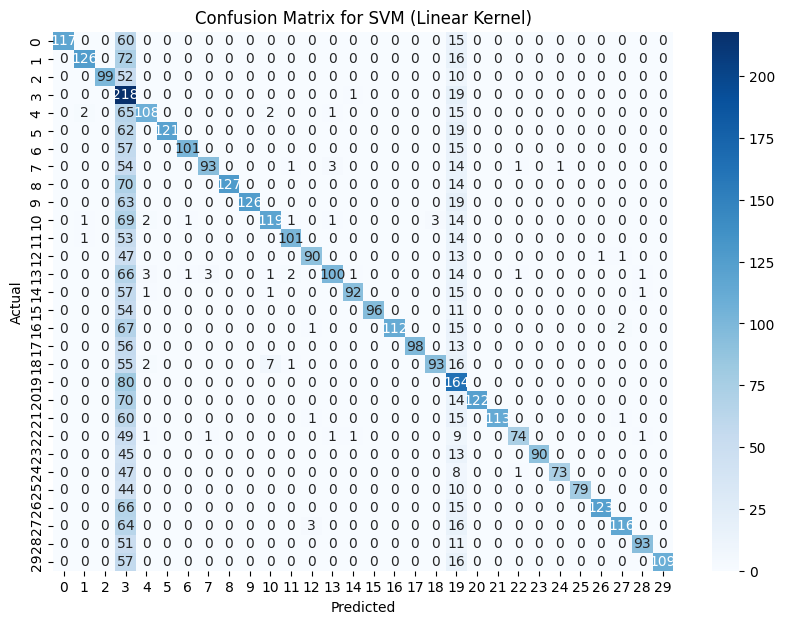

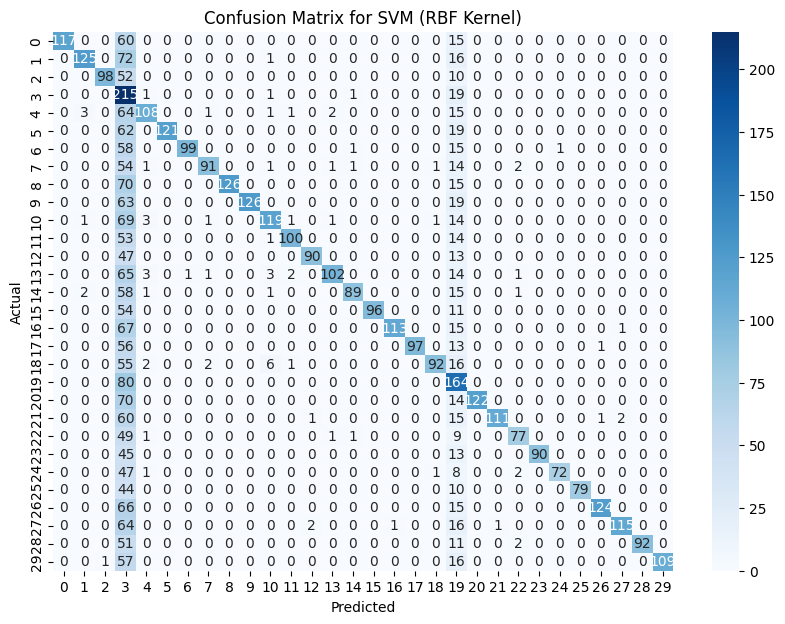

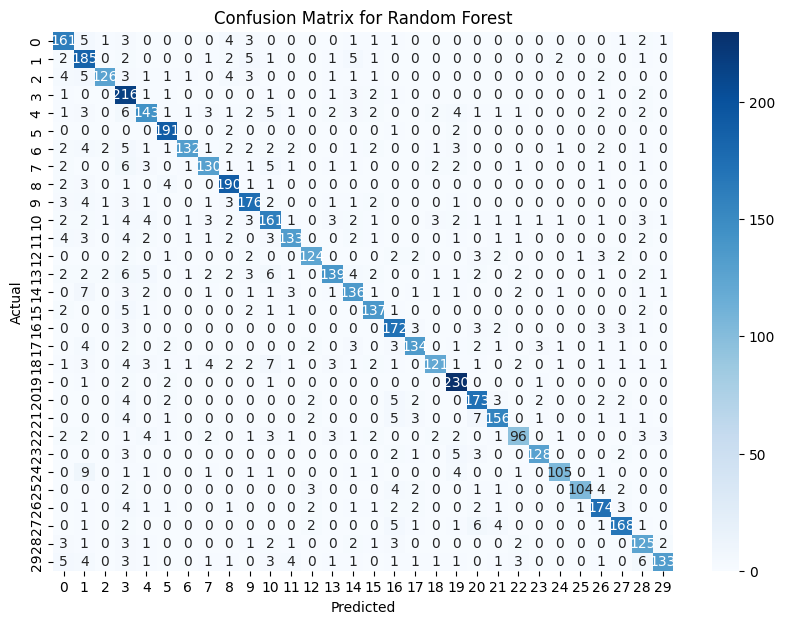

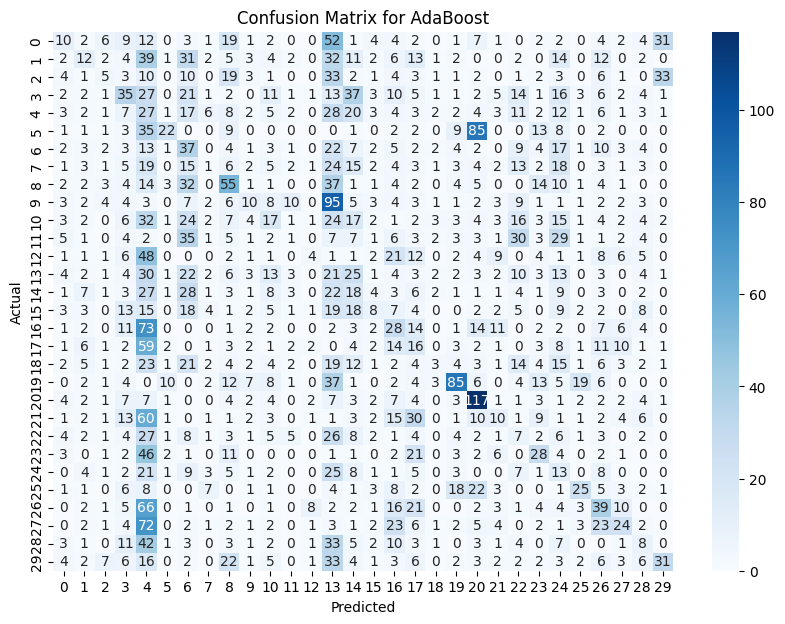

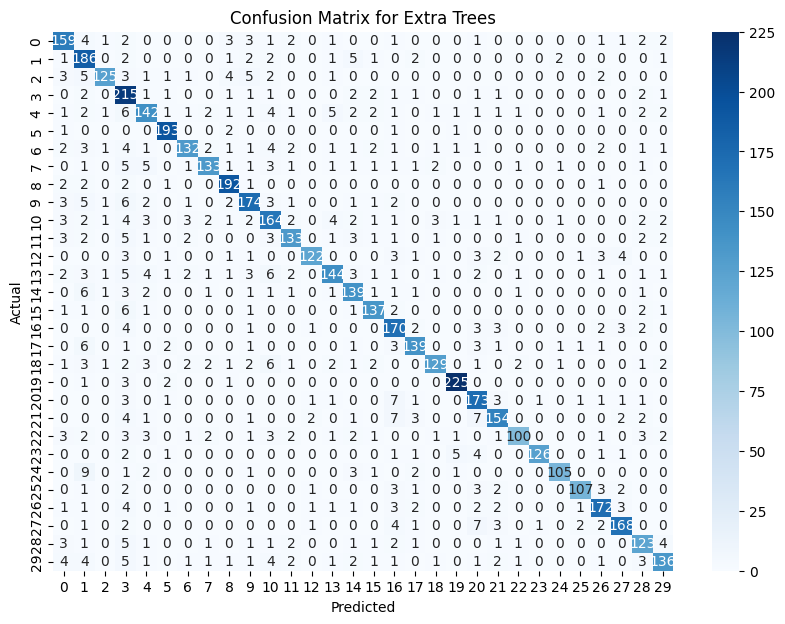


Confusion Matrix for Extra Trees:
[[189   8   1   4   0   1   1   0   2   0   4   2   0   1   2   1   2   0
    0   0   1   1   1   0   0   0   1   1   2   4]
 [  2 242   0   1   0   0   1   1   1   3   1   1   0   1   4   0   2   2
    0   0   0   1   0   0   3   0   0   0   0   1]
 [  4   3 177   1   2   1   3   0   5  11   2   4   0   3   3   2   0   0
    1   2   0   1   0   0   0   0   4   0   0   0]
 [  2   1   0 278   0   0   2   0   2   0   1   0   0   2   1   4   2   1
    0   0   1   0   0   0   0   0   1   1   4   0]
 [  1   2   4   7 194   1   3   2   5   3   7   0   0   3   2   1   1   1
    1   3   1   1   1   0   0   0   2   0   5   0]
 [  0   0   0   2   0 250   0   0   2   0   0   0   0   1   0   0   0   0
    0   1   0   0   0   0   0   0   0   0   0   0]
 [  4   2   0   7   2   0 194   1   2   2   7   0   1   0   1   1   1   0
    2   3   2   0   1   1   2   1   1   3   1   0]
 [  3   5   0   4   5   0   2 148   1   2   3   1   0   0   1   0   1   0
    0   2   3   

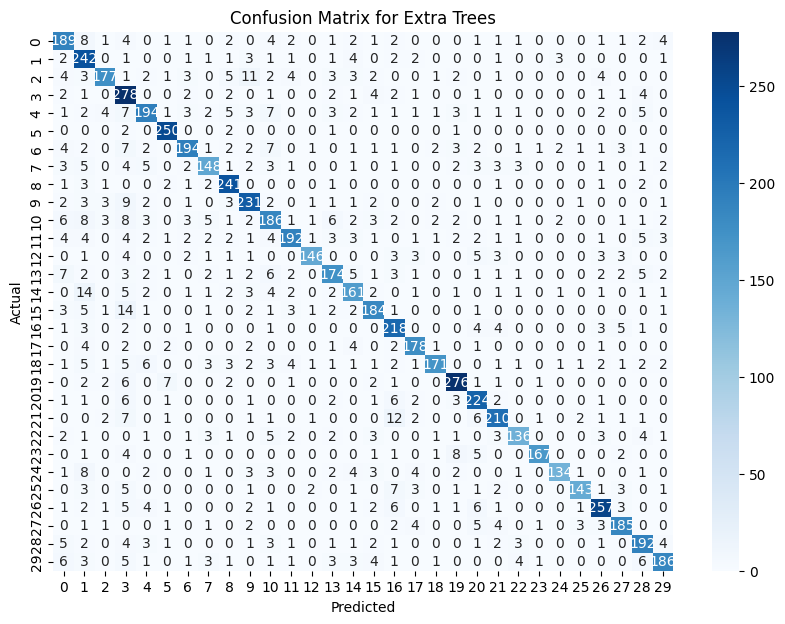

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/forklift_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=5):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.5914
SVM (RBF Kernel) Average Accuracy: 0.5833
Random Forest Average Accuracy: 0.7920
AdaBoost Average Accuracy: 0.1228
Extra Trees Average Accuracy: 0.8002

Best performing model: Extra Trees with Average Accuracy: 0.8002

Test Accuracy of the best model (Extra Trees): 0.8138


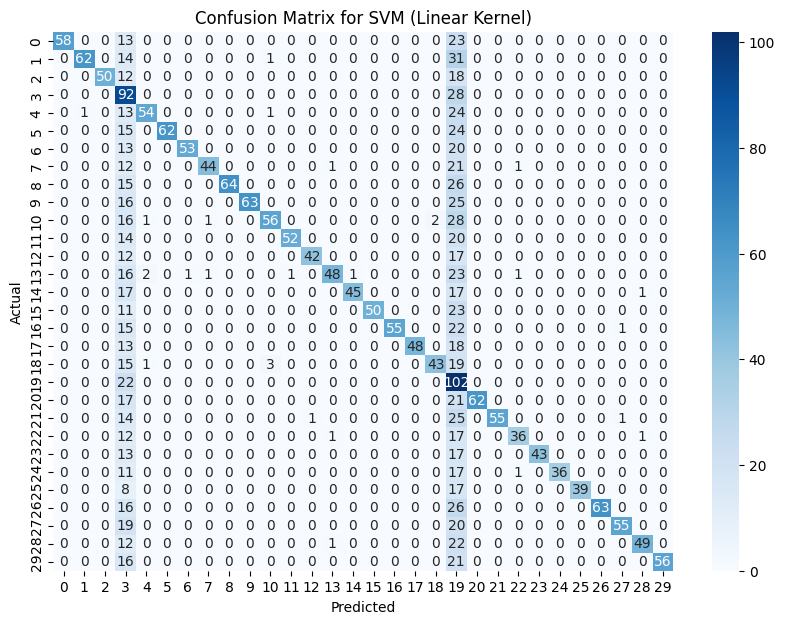

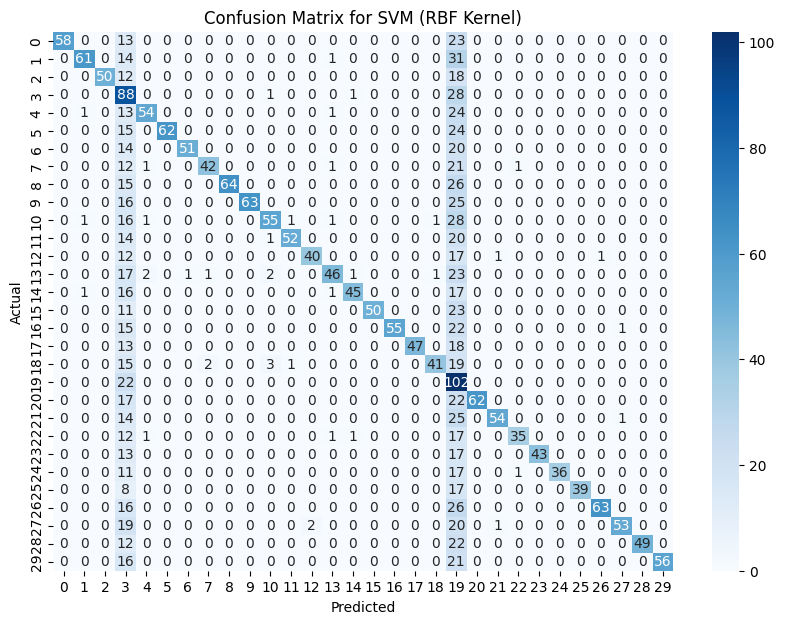

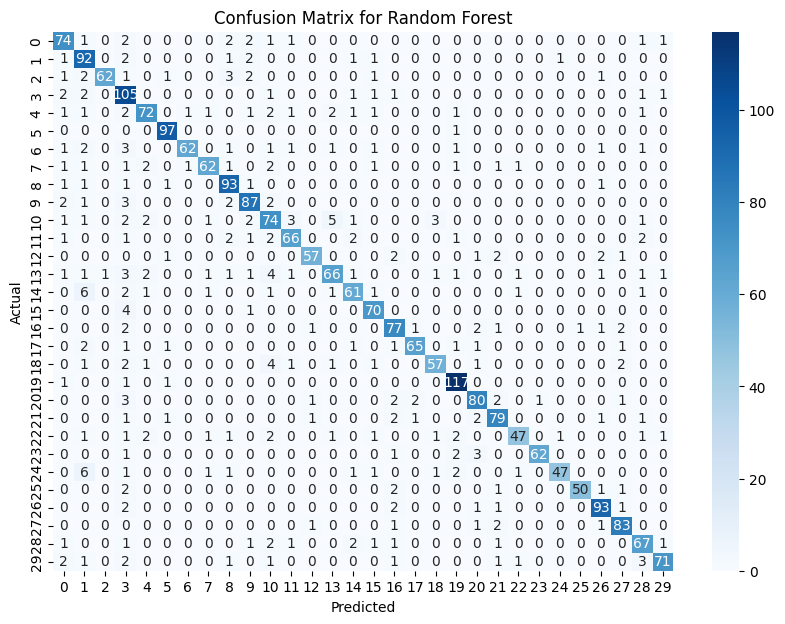

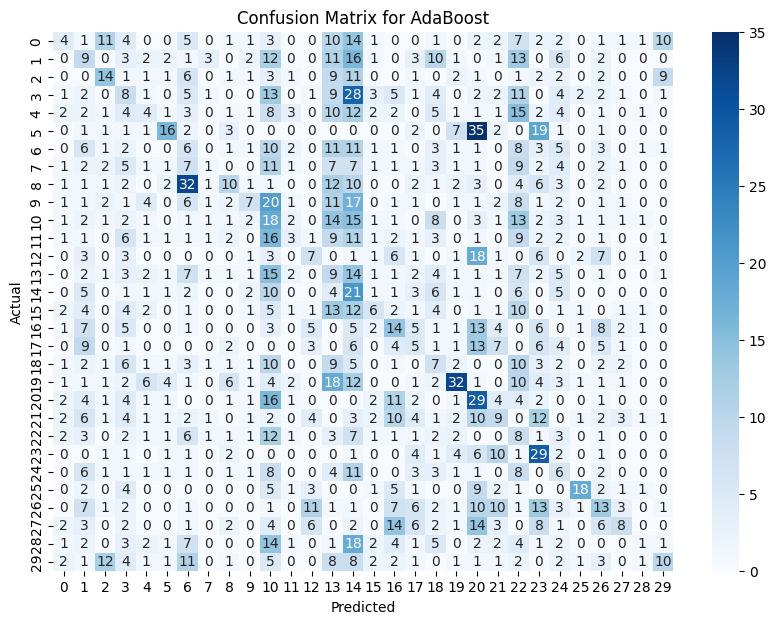

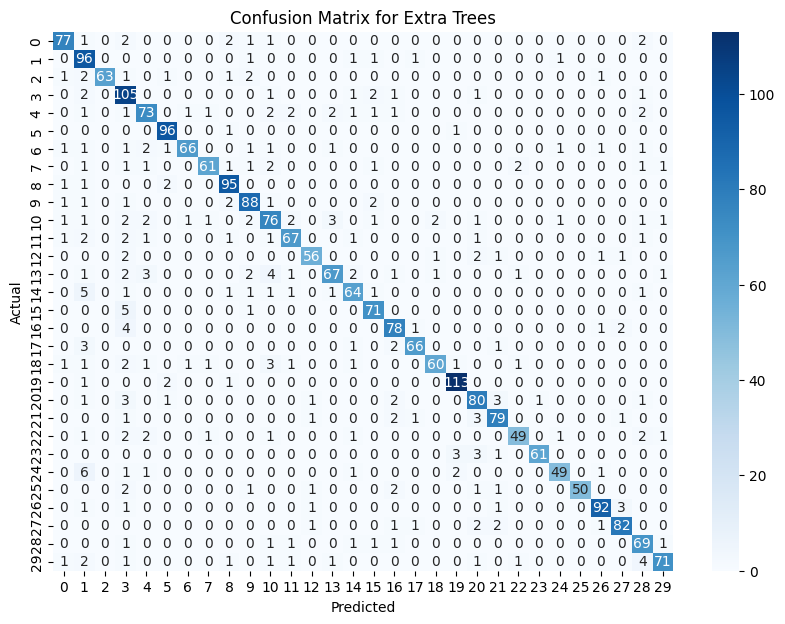


Confusion Matrix for Extra Trees:
[[100   0   0   3   0   0   0   1   2   2   1   0   0   1   2   1   0   2
    0   0   1   3   1   0   0   0   0   0   2   1]
 [  0 116   2   0   0   0   0   0   3   4   0   0   0   1   0   0   0   2
    1   0   0   0   0   0   1   0   0   0   0   1]
 [  3   2  83   3   0   1   0   0   2   9   1   0   0   3   0   0   0   1
    2   0   0   0   1   0   0   0   1   0   0   0]
 [  0   2   0 129   0   0   0   0   0   1   0   1   0   0   0   3   0   0
    0   0   3   0   0   0   0   0   0   0   1   0]
 [  1   3   0   4  86   0   0   3   2   0   4   1   0   3   4   3   0   0
    2   2   3   0   4   0   0   0   4   0   2   0]
 [  0   0   0   0   0 119   0   0   2   0   0   0   0   0   0   1   1   0
    0   1   0   0   0   0   0   0   1   0   0   0]
 [  0   1   1   5   0   0  86   0   2   1   3   3   0   1   0   2   2   0
    0   2   1   0   1   0   1   0   1   2   4   1]
 [  1   0   0   2   2   0   4  83   0   3   4   1   0   0   0   2   1   1
    0   2   0   

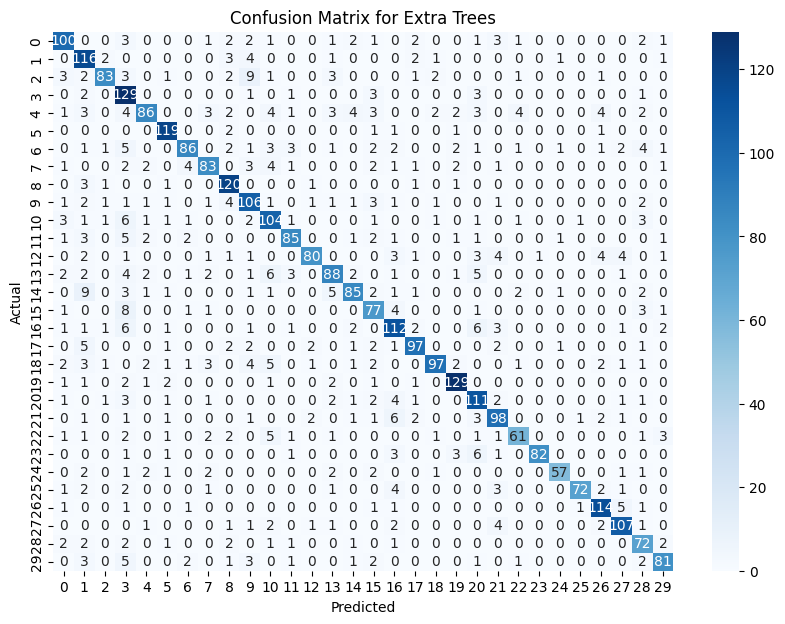

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/forklift_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=10):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


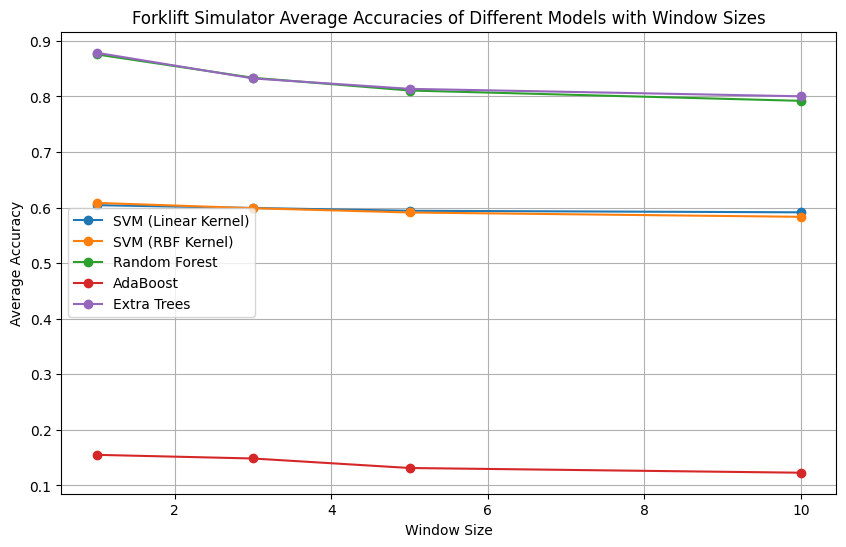

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define window sizes and average accuracies for each model
window_sizes = [1, 3, 5, 10]
svm_linear_accuracies = [0.6043,0.5992,0.5942,0.5914]
svm_rbf_accuracies = [ 0.6084,0.5988,0.5911, 0.5833]
random_forest_accuracies = [0.8756,0.8335,0.8106,0.7920]
adaboost_accuracies = [0.1550, 0.1484,0.1313,0.1228]
extra_trees_accuracies = [0.8786,0.8323,0.8136,0.8002]

# Plotting the graph
plt.figure(figsize=(10, 6))

plt.plot(window_sizes, svm_linear_accuracies, marker='o', label='SVM (Linear Kernel)')
plt.plot(window_sizes, svm_rbf_accuracies, marker='o', label='SVM (RBF Kernel)')
plt.plot(window_sizes, random_forest_accuracies, marker='o', label='Random Forest')
plt.plot(window_sizes, adaboost_accuracies, marker='o', label='AdaBoost')
plt.plot(window_sizes, extra_trees_accuracies, marker='o', label='Extra Trees')

plt.title('Forklift Simulator Average Accuracies of Different Models with Window Sizes')
plt.xlabel('Window Size')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()
